In [1]:
import torch
from vit_pytorch import ViT
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary
from einops.layers.torch import Rearrange, Reduce

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/jo/anaconda3/envs/build/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/jo/anaconda3/envs/build/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'base_path': '/home/jo/Desktop/swdacon/open/', # change relative path of data
    'train_data': 'train.csv', # change train data csv name
    'test_data': 'test.csv', # change test data csv name
    'seed': 42,
    'valid_size': 0.2,
    'early_stopping': 15,
    'scheduler': True,
    'train' : {
       'batch_size' : 16,
       'num_workers': 6,
       'epochs': 300,
       'lr': 1e-3,
    },
    'inference' : {
       'batch_size' : 16,
       'num_workers': 6,
       'threshold': 0.35,
    },
}

custom_transform = {
    'train':A.Compose([
        A.augmentations.crops.transforms.RandomCrop(224,224,p=1.0),
        A.Normalize(),
        ToTensorV2()
    ]),
    'valid':A.Compose([
        A.augmentations.crops.transforms.CenterCrop(224,224,p=1.0),
        A.Normalize(),
        ToTensorV2()
    ]),
    'test': A.Compose([
        A.Normalize(),
        ToTensorV2()
    ]),
}

In [3]:
config['device']

device(type='cuda')

## Model

In [4]:
vit_encoder = ViT(
    image_size=14,
    patch_size=1,
    dim = 1024,
    depth=12,
    num_classes=2,
    heads=8,
    mlp_dim=2048,
)
vit_encoder=vit_encoder.to(config['device'])
# vit_encoder = nn.DataParallel(vit_encoder)

In [5]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )
class TransUnet(nn.Module):
    def __init__(self):
        super(TransUnet, self).__init__()
        self.backbone = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        self.vit_flatten = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=1, p2=1),
            nn.LayerNorm(1024)
        )
        self.conv_vit_res = nn.Sequential(
            nn.Conv2d(1024,512,3,1,1),
            nn.ReLU(inplace=True)
        )
        self.res_conv = nn.Sequential(
            nn.Conv2d(64,16,3,1,1),
            nn.ReLU(inplace=True)
        )
        self.seg_conv = nn.Conv2d(16, 1, 1)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(512 + 512, 256)
        self.dconv_up2 = double_conv(256 + 256, 128)
        self.dconv_up1 = double_conv(64 + 128, 64)

        self.conv_last = nn.Conv2d(16, 1, 1)
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        out1 = self.backbone.maxpool(x)
        out2 = self.backbone.layer1(out1)
        out3 = self.backbone.layer2(out2)
        out4 = self.backbone.layer3(out3)

        vit_out = self.vit_flatten(out4)
        vit_out = vit_encoder.transformer(vit_out)
        vit_out = vit_out.reshape(-1,1024,14,14)
        vit_out = self.conv_vit_res(vit_out)
        up3 = self.upsample(vit_out)
        up3 = up3.to(out3.device)
        up3 = torch.cat([up3, out3], dim=1)
        up3 = self.dconv_up3(up3)
        up2 = self.upsample(up3)
        up2 = up2.to(out2.device)

        up2 = torch.cat([up2, out2], dim=1)
        up2 = self.dconv_up2(up2)

        up1 = self.upsample(up2)
        up1 = up1.to(x.device)
        up1 = torch.cat([up1,x],dim=1)
        up1 = self.dconv_up1(up1)

        up0 = self.upsample(up1)
        up0 = self.res_conv(up0)
        res = self.seg_conv(up0)
        return res

In [6]:
model = TransUnet().to(config['device'])
summary(model,(3,224,224),device=config['device'].type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## utils

In [7]:
import random
import numpy as np
from typing import List, Union
from joblib import Parallel, delayed
import os
import torch.nn.functional as F

In [8]:

# 시드 고정 함수
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

# RLE 디코딩 함수
def rle_decode(mask_rle: Union[str, int], shape=(224, 224)) -> np.array:
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    if mask_rle == -1:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# dice score 계산 함수
def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)

def calculate_dice_scores(validation_df, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''
    # Extract the mask_rle columns
    pred_mask_rle = validation_df.iloc[:, 3]
    gt_mask_rle = validation_df.iloc[:, 4]

    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)
        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None
    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle)
    )
    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values
    return np.mean(dice_scores)

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

## Dataset

In [9]:
from torch.utils.data import Dataset, DataLoader
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split

In [10]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, mask_rles = None, transform=None, infer=False):
        self.img_paths = img_paths
        self.mask_rles = mask_rles
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths.iloc[idx]
        image = cv2.imread(config['base_path']+img_path[2:])

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.mask_rles.iloc[idx]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [11]:
# 로컬 사용시 활성화

train_df = pd.read_csv(f"{config['base_path']}/{config['train_data']}")
train, val = train_test_split(train_df, test_size=config['valid_size'], random_state=config['seed'])
print("train: ", len(train), "   valid: ", len(val))

train:  5712    valid:  1428


In [12]:
fix_seed(config['seed'])

train_dataset = CustomDataset(img_paths=train['img_path'], mask_rles=train['mask_rle'], transform=custom_transform['train'])
train_dataloader = DataLoader(train_dataset, batch_size=config['train']['batch_size'], shuffle=True, num_workers=config['train']['num_workers'])

valid_dataset = CustomDataset(img_paths=val['img_path'], mask_rles=val['mask_rle'], transform=custom_transform['valid'])
valid_dataloader = DataLoader(valid_dataset , batch_size=config['train']['batch_size'], shuffle=False, num_workers=config['train']['num_workers'])

## train/vali

In [13]:
def validation(config, model, criterion, valid_loader, val):
    model.eval()
    valid_loss = 0
    result = []
    transformed_mask = []
    val_df = val.copy()

    with torch.no_grad():
        for images, masks in tqdm(valid_loader):
            if type(transformed_mask) == torch.Tensor:
                transformed_mask = torch.cat([transformed_mask, masks])
            else:
                transformed_mask = masks.clone().detach()
            images = images.float().to(config['device'])
            masks = masks.float().to(config['device'])

            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            valid_loss += loss.item()

            output_masks = torch.sigmoid(outputs).cpu().numpy()
            output_masks = np.squeeze(output_masks, axis=1)
            output_masks = (output_masks > config['inference']['threshold']).astype(np.uint8)

            for i in range(len(images)):
                mask_rle = rle_encode(output_masks[i])
                if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                    result.append(-1)
                else:
                    result.append(mask_rle)
        val_df['valid_mask_rle'] = result
        val_df['transformed_mask_rle'] = list(map(rle_encode, transformed_mask.squeeze().numpy()))
        dice_score = calculate_dice_scores(val_df)

    return valid_loss/len(valid_loader), dice_score

In [14]:
def training(config, model, train_loader, valid_loader, val):
    model = model.to(config['device'])
    es_count = 0
    min_val_loss = float('inf')
    best_model = None

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['train']['lr'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, min_lr=1e-8, verbose=True)

    # training loop
    for epoch in range(config['train']['epochs']):
        model.train()
        epoch_loss = 0
        for images, masks in tqdm(train_loader):
            images = images.float().to(config['device'])
            masks = masks.float().to(config['device'])

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        val_loss, dice_score = validation(config, model, criterion, valid_loader, val)
        es_count += 1
        if min_val_loss > val_loss:
            es_count = 0
            min_val_loss = val_loss
            best_model = model
            best_epoch = epoch + 1
            print(f"Epoch [{epoch + 1}] New Minimum Valid Loss!")

        if config['scheduler']:
            scheduler.step(val_loss)

        if es_count == config['early_stopping']:
            print(f'Epoch {epoch+1}, Train Loss: {(epoch_loss/len(train_loader)):6f}, Valid Loss: {val_loss:6f}, Dice Coefficient: {dice_score:6f}, ES Count:, {es_count}')
            print(f"EARLY STOPPING COUNT에 도달했습니다! \nEARLY STOPPING COUNT: {config['early_stopping']} BEST EPOCH: {best_epoch}")
            print("***TRAINING DONE***")
            return best_model

        print(f'Epoch {epoch+1}, Train Loss: {(epoch_loss/len(train_loader)):6f}, Valid Loss: {val_loss:6f}, Dice Coefficient: {dice_score:6f} ES Count:, {es_count}')
        print("------------------------------------------------------------------------------------")

    print(f"EARLY STOPPING COUNT에 도달하지 않았습니다! \nEARLY STOPPING COUNT: {config['early_stopping']} BEST EPOCH: {best_epoch}")
    print("***TRAINING DONE***")
    return best_model

In [15]:
torch.cuda.is_available() # 학습 전에 GPU 쓰고 있나 확인

True

In [16]:
best_model = training(config, model, train_dataloader, valid_dataloader, val)

100%|██████████| 90/90 [00:09<00:00,  9.21it/s]


Epoch [1] New Minimum Valid Loss!
Epoch 1, Train Loss: 0.152824, Valid Loss: 0.107637, Dice Coefficient: 0.501177 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.56it/s]


Epoch [2] New Minimum Valid Loss!
Epoch 2, Train Loss: 0.098064, Valid Loss: 0.087344, Dice Coefficient: 0.585850 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.65it/s]


Epoch [3] New Minimum Valid Loss!
Epoch 3, Train Loss: 0.086790, Valid Loss: 0.081224, Dice Coefficient: 0.627097 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.69it/s]


Epoch 4, Train Loss: 0.084772, Valid Loss: 0.084780, Dice Coefficient: 0.621699 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.71it/s]


Epoch [5] New Minimum Valid Loss!
Epoch 5, Train Loss: 0.081848, Valid Loss: 0.075633, Dice Coefficient: 0.634970 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.73it/s]


Epoch [6] New Minimum Valid Loss!
Epoch 6, Train Loss: 0.078843, Valid Loss: 0.070807, Dice Coefficient: 0.650077 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.77it/s]


Epoch [7] New Minimum Valid Loss!
Epoch 7, Train Loss: 0.080196, Valid Loss: 0.069317, Dice Coefficient: 0.668091 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch [8] New Minimum Valid Loss!
Epoch 8, Train Loss: 0.074314, Valid Loss: 0.067506, Dice Coefficient: 0.681427 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch 9, Train Loss: 0.070944, Valid Loss: 0.074843, Dice Coefficient: 0.645838 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.70it/s]


Epoch [10] New Minimum Valid Loss!
Epoch 10, Train Loss: 0.072346, Valid Loss: 0.066095, Dice Coefficient: 0.674268 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.69it/s]


Epoch [11] New Minimum Valid Loss!
Epoch 11, Train Loss: 0.070456, Valid Loss: 0.064788, Dice Coefficient: 0.684726 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch 12, Train Loss: 0.073654, Valid Loss: 0.066351, Dice Coefficient: 0.683610 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.72it/s]


Epoch 13, Train Loss: 0.068144, Valid Loss: 0.065849, Dice Coefficient: 0.679196 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.71it/s]


Epoch 14, Train Loss: 0.066453, Valid Loss: 0.065936, Dice Coefficient: 0.678139 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.67it/s]


Epoch 15, Train Loss: 0.067402, Valid Loss: 0.078741, Dice Coefficient: 0.652273 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.
Epoch 16, Train Loss: 0.066886, Valid Loss: 0.083965, Dice Coefficient: 0.635007 ES Count:, 5
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch [17] New Minimum Valid Loss!
Epoch 17, Train Loss: 0.060580, Valid Loss: 0.060086, Dice Coefficient: 0.702999 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.76it/s]


Epoch 18, Train Loss: 0.061659, Valid Loss: 0.061229, Dice Coefficient: 0.689330 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.71it/s]


Epoch 19, Train Loss: 0.061923, Valid Loss: 0.069951, Dice Coefficient: 0.651871 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch [20] New Minimum Valid Loss!
Epoch 20, Train Loss: 0.060622, Valid Loss: 0.057605, Dice Coefficient: 0.717771 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch 21, Train Loss: 0.061594, Valid Loss: 0.061059, Dice Coefficient: 0.687824 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.76it/s]


Epoch [22] New Minimum Valid Loss!
Epoch 22, Train Loss: 0.056645, Valid Loss: 0.056486, Dice Coefficient: 0.721473 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.73it/s]


Epoch 23, Train Loss: 0.058337, Valid Loss: 0.057955, Dice Coefficient: 0.708610 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.67it/s]


Epoch 24, Train Loss: 0.056816, Valid Loss: 0.059215, Dice Coefficient: 0.679298 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.76it/s]


Epoch 25, Train Loss: 0.057376, Valid Loss: 0.057178, Dice Coefficient: 0.722240 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.78it/s]


Epoch [26] New Minimum Valid Loss!
Epoch 26, Train Loss: 0.058705, Valid Loss: 0.054346, Dice Coefficient: 0.721683 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.70it/s]


Epoch 27, Train Loss: 0.056636, Valid Loss: 0.058174, Dice Coefficient: 0.708487 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.75it/s]


Epoch 28, Train Loss: 0.057177, Valid Loss: 0.055861, Dice Coefficient: 0.721703 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.70it/s]


Epoch 29, Train Loss: 0.056379, Valid Loss: 0.055073, Dice Coefficient: 0.724126 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.72it/s]


Epoch 30, Train Loss: 0.060123, Valid Loss: 0.068000, Dice Coefficient: 0.674525 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.72it/s]


Epoch 00031: reducing learning rate of group 0 to 2.5000e-04.
Epoch 31, Train Loss: 0.058091, Valid Loss: 0.057747, Dice Coefficient: 0.705548 ES Count:, 5
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.70it/s]


Epoch [32] New Minimum Valid Loss!
Epoch 32, Train Loss: 0.056331, Valid Loss: 0.053775, Dice Coefficient: 0.724915 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.73it/s]


Epoch 33, Train Loss: 0.053783, Valid Loss: 0.055841, Dice Coefficient: 0.720837 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.77it/s]


Epoch [34] New Minimum Valid Loss!
Epoch 34, Train Loss: 0.054897, Valid Loss: 0.053418, Dice Coefficient: 0.734228 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.77it/s]


Epoch [35] New Minimum Valid Loss!
Epoch 35, Train Loss: 0.055069, Valid Loss: 0.053405, Dice Coefficient: 0.727206 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.67it/s]


Epoch [36] New Minimum Valid Loss!
Epoch 36, Train Loss: 0.052576, Valid Loss: 0.053356, Dice Coefficient: 0.723533 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.72it/s]


Epoch [37] New Minimum Valid Loss!
Epoch 37, Train Loss: 0.053078, Valid Loss: 0.052932, Dice Coefficient: 0.736922 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.72it/s]


Epoch 38, Train Loss: 0.052966, Valid Loss: 0.053054, Dice Coefficient: 0.730744 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.69it/s]


Epoch [39] New Minimum Valid Loss!
Epoch 39, Train Loss: 0.053839, Valid Loss: 0.052731, Dice Coefficient: 0.734284 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.76it/s]


Epoch [40] New Minimum Valid Loss!
Epoch 40, Train Loss: 0.050460, Valid Loss: 0.051600, Dice Coefficient: 0.731642 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.68it/s]


Epoch 41, Train Loss: 0.053420, Valid Loss: 0.052548, Dice Coefficient: 0.733133 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.61it/s]


Epoch 42, Train Loss: 0.053788, Valid Loss: 0.053123, Dice Coefficient: 0.736061 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.75it/s]


Epoch 43, Train Loss: 0.052572, Valid Loss: 0.052634, Dice Coefficient: 0.733077 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch 44, Train Loss: 0.051409, Valid Loss: 0.053232, Dice Coefficient: 0.731296 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch 00045: reducing learning rate of group 0 to 1.2500e-04.
Epoch 45, Train Loss: 0.052252, Valid Loss: 0.051711, Dice Coefficient: 0.735377 ES Count:, 5
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.63it/s]


Epoch [46] New Minimum Valid Loss!
Epoch 46, Train Loss: 0.052100, Valid Loss: 0.050924, Dice Coefficient: 0.740716 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.76it/s]


Epoch [47] New Minimum Valid Loss!
Epoch 47, Train Loss: 0.049336, Valid Loss: 0.050187, Dice Coefficient: 0.742571 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.66it/s]


Epoch 48, Train Loss: 0.049516, Valid Loss: 0.051165, Dice Coefficient: 0.736353 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.69it/s]


Epoch 49, Train Loss: 0.049861, Valid Loss: 0.050819, Dice Coefficient: 0.741665 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.71it/s]


Epoch 50, Train Loss: 0.048703, Valid Loss: 0.051133, Dice Coefficient: 0.742199 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.75it/s]


Epoch 51, Train Loss: 0.051261, Valid Loss: 0.051011, Dice Coefficient: 0.737676 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.68it/s]


Epoch [52] New Minimum Valid Loss!
Epoch 52, Train Loss: 0.049485, Valid Loss: 0.049691, Dice Coefficient: 0.744273 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.78it/s]


Epoch 53, Train Loss: 0.050098, Valid Loss: 0.050412, Dice Coefficient: 0.748483 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.68it/s]


Epoch 54, Train Loss: 0.049048, Valid Loss: 0.049711, Dice Coefficient: 0.743692 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.66it/s]


Epoch 55, Train Loss: 0.048920, Valid Loss: 0.049707, Dice Coefficient: 0.747562 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.69it/s]


Epoch 56, Train Loss: 0.049490, Valid Loss: 0.050020, Dice Coefficient: 0.743282 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.78it/s]


Epoch 00057: reducing learning rate of group 0 to 6.2500e-05.
Epoch 57, Train Loss: 0.049350, Valid Loss: 0.050081, Dice Coefficient: 0.744426 ES Count:, 5
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.71it/s]


Epoch [58] New Minimum Valid Loss!
Epoch 58, Train Loss: 0.047642, Valid Loss: 0.049474, Dice Coefficient: 0.747667 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch [59] New Minimum Valid Loss!
Epoch 59, Train Loss: 0.047459, Valid Loss: 0.048930, Dice Coefficient: 0.751713 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.66it/s]


Epoch 60, Train Loss: 0.048211, Valid Loss: 0.049118, Dice Coefficient: 0.749277 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.71it/s]


Epoch 61, Train Loss: 0.048275, Valid Loss: 0.049369, Dice Coefficient: 0.749294 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch 62, Train Loss: 0.047390, Valid Loss: 0.049216, Dice Coefficient: 0.749614 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.76it/s]


Epoch [63] New Minimum Valid Loss!
Epoch 63, Train Loss: 0.047998, Valid Loss: 0.048832, Dice Coefficient: 0.747369 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch [64] New Minimum Valid Loss!
Epoch 64, Train Loss: 0.048505, Valid Loss: 0.048803, Dice Coefficient: 0.750090 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.72it/s]


Epoch [65] New Minimum Valid Loss!
Epoch 65, Train Loss: 0.048364, Valid Loss: 0.048631, Dice Coefficient: 0.748495 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.72it/s]


Epoch 66, Train Loss: 0.048046, Valid Loss: 0.048948, Dice Coefficient: 0.747960 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.77it/s]


Epoch 67, Train Loss: 0.047636, Valid Loss: 0.048991, Dice Coefficient: 0.750065 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.67it/s]


Epoch 68, Train Loss: 0.047072, Valid Loss: 0.049069, Dice Coefficient: 0.750724 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.67it/s]


Epoch 69, Train Loss: 0.048402, Valid Loss: 0.048869, Dice Coefficient: 0.751318 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.77it/s]


Epoch 00070: reducing learning rate of group 0 to 3.1250e-05.
Epoch 70, Train Loss: 0.048224, Valid Loss: 0.048968, Dice Coefficient: 0.752180 ES Count:, 5
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.76it/s]


Epoch 71, Train Loss: 0.047558, Valid Loss: 0.048734, Dice Coefficient: 0.751502 ES Count:, 6
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.76it/s]


Epoch [72] New Minimum Valid Loss!
Epoch 72, Train Loss: 0.048189, Valid Loss: 0.048565, Dice Coefficient: 0.751381 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.72it/s]


Epoch [73] New Minimum Valid Loss!
Epoch 73, Train Loss: 0.047665, Valid Loss: 0.048507, Dice Coefficient: 0.751721 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.79it/s]


Epoch 74, Train Loss: 0.047703, Valid Loss: 0.048744, Dice Coefficient: 0.748605 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch 75, Train Loss: 0.047279, Valid Loss: 0.048740, Dice Coefficient: 0.750434 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.72it/s]


Epoch 76, Train Loss: 0.048179, Valid Loss: 0.048756, Dice Coefficient: 0.750219 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.72it/s]


Epoch 77, Train Loss: 0.047841, Valid Loss: 0.048816, Dice Coefficient: 0.750259 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.79it/s]


Epoch [78] New Minimum Valid Loss!
Epoch 78, Train Loss: 0.047617, Valid Loss: 0.048494, Dice Coefficient: 0.751301 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.72it/s]


Epoch [79] New Minimum Valid Loss!
Epoch 79, Train Loss: 0.047282, Valid Loss: 0.048293, Dice Coefficient: 0.753380 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch 80, Train Loss: 0.049163, Valid Loss: 0.048730, Dice Coefficient: 0.751032 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.78it/s]


Epoch 81, Train Loss: 0.047125, Valid Loss: 0.048518, Dice Coefficient: 0.750426 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.73it/s]


Epoch 82, Train Loss: 0.048854, Valid Loss: 0.048750, Dice Coefficient: 0.750024 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.75it/s]


Epoch 83, Train Loss: 0.047311, Valid Loss: 0.048520, Dice Coefficient: 0.748685 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.80it/s]


Epoch 00084: reducing learning rate of group 0 to 1.5625e-05.
Epoch 84, Train Loss: 0.047891, Valid Loss: 0.048435, Dice Coefficient: 0.750440 ES Count:, 5
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.71it/s]


Epoch [85] New Minimum Valid Loss!
Epoch 85, Train Loss: 0.047654, Valid Loss: 0.048168, Dice Coefficient: 0.751503 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.81it/s]


Epoch 86, Train Loss: 0.045434, Valid Loss: 0.048356, Dice Coefficient: 0.752897 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch [87] New Minimum Valid Loss!
Epoch 87, Train Loss: 0.047464, Valid Loss: 0.048061, Dice Coefficient: 0.751115 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.71it/s]


Epoch 88, Train Loss: 0.047759, Valid Loss: 0.048197, Dice Coefficient: 0.752657 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.72it/s]


Epoch 89, Train Loss: 0.047104, Valid Loss: 0.048397, Dice Coefficient: 0.752608 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch 90, Train Loss: 0.047185, Valid Loss: 0.048222, Dice Coefficient: 0.753359 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.73it/s]


Epoch 91, Train Loss: 0.045920, Valid Loss: 0.048292, Dice Coefficient: 0.751825 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.66it/s]


Epoch 00092: reducing learning rate of group 0 to 7.8125e-06.
Epoch 92, Train Loss: 0.046920, Valid Loss: 0.048429, Dice Coefficient: 0.753650 ES Count:, 5
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.74it/s]


Epoch 93, Train Loss: 0.046675, Valid Loss: 0.048289, Dice Coefficient: 0.752876 ES Count:, 6
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.72it/s]


Epoch [94] New Minimum Valid Loss!
Epoch 94, Train Loss: 0.046721, Valid Loss: 0.048055, Dice Coefficient: 0.753462 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.68it/s]


Epoch 95, Train Loss: 0.046567, Valid Loss: 0.048216, Dice Coefficient: 0.752957 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.77it/s]


Epoch 96, Train Loss: 0.046621, Valid Loss: 0.048420, Dice Coefficient: 0.752949 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.02it/s]


Epoch 97, Train Loss: 0.046298, Valid Loss: 0.048061, Dice Coefficient: 0.753331 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.46it/s]


Epoch 98, Train Loss: 0.046861, Valid Loss: 0.048312, Dice Coefficient: 0.753054 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.65it/s]


Epoch 00099: reducing learning rate of group 0 to 3.9063e-06.
Epoch 99, Train Loss: 0.046918, Valid Loss: 0.048113, Dice Coefficient: 0.753092 ES Count:, 5
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.64it/s]


Epoch 100, Train Loss: 0.048370, Valid Loss: 0.048059, Dice Coefficient: 0.750889 ES Count:, 6
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.66it/s]


Epoch [101] New Minimum Valid Loss!
Epoch 101, Train Loss: 0.046284, Valid Loss: 0.047970, Dice Coefficient: 0.753151 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.76it/s]


Epoch 102, Train Loss: 0.046293, Valid Loss: 0.048160, Dice Coefficient: 0.753446 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.63it/s]


Epoch 103, Train Loss: 0.046493, Valid Loss: 0.048131, Dice Coefficient: 0.753097 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.64it/s]


Epoch 104, Train Loss: 0.047262, Valid Loss: 0.048023, Dice Coefficient: 0.754284 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.63it/s]


Epoch 105, Train Loss: 0.047098, Valid Loss: 0.048105, Dice Coefficient: 0.754011 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.72it/s]


Epoch [106] New Minimum Valid Loss!
Epoch 106, Train Loss: 0.048148, Valid Loss: 0.047936, Dice Coefficient: 0.753333 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.58it/s]


Epoch 107, Train Loss: 0.046824, Valid Loss: 0.048199, Dice Coefficient: 0.753113 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.70it/s]


Epoch 108, Train Loss: 0.046331, Valid Loss: 0.048028, Dice Coefficient: 0.752311 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.59it/s]


Epoch 109, Train Loss: 0.047387, Valid Loss: 0.048165, Dice Coefficient: 0.751773 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.63it/s]


Epoch [110] New Minimum Valid Loss!
Epoch 110, Train Loss: 0.047403, Valid Loss: 0.047749, Dice Coefficient: 0.753469 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.56it/s]


Epoch 111, Train Loss: 0.047296, Valid Loss: 0.048046, Dice Coefficient: 0.751703 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.63it/s]


Epoch 112, Train Loss: 0.046392, Valid Loss: 0.048050, Dice Coefficient: 0.754367 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.71it/s]


Epoch 113, Train Loss: 0.047524, Valid Loss: 0.048050, Dice Coefficient: 0.753995 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.62it/s]


Epoch 114, Train Loss: 0.047368, Valid Loss: 0.048112, Dice Coefficient: 0.752553 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.62it/s]


Epoch 00115: reducing learning rate of group 0 to 1.9531e-06.
Epoch 115, Train Loss: 0.048279, Valid Loss: 0.048141, Dice Coefficient: 0.753393 ES Count:, 5
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.64it/s]


Epoch 116, Train Loss: 0.048496, Valid Loss: 0.048097, Dice Coefficient: 0.754830 ES Count:, 6
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.67it/s]


Epoch 117, Train Loss: 0.047686, Valid Loss: 0.048020, Dice Coefficient: 0.753714 ES Count:, 7
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.71it/s]


Epoch 118, Train Loss: 0.045964, Valid Loss: 0.047843, Dice Coefficient: 0.752207 ES Count:, 8
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.64it/s]


Epoch 119, Train Loss: 0.047547, Valid Loss: 0.047905, Dice Coefficient: 0.753377 ES Count:, 9
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.60it/s]


Epoch 00120: reducing learning rate of group 0 to 9.7656e-07.
Epoch 120, Train Loss: 0.048187, Valid Loss: 0.047955, Dice Coefficient: 0.754349 ES Count:, 10
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.69it/s]


Epoch 121, Train Loss: 0.047250, Valid Loss: 0.048029, Dice Coefficient: 0.751867 ES Count:, 11
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.59it/s]


Epoch 122, Train Loss: 0.046211, Valid Loss: 0.048009, Dice Coefficient: 0.752342 ES Count:, 12
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.61it/s]


Epoch 123, Train Loss: 0.046854, Valid Loss: 0.047868, Dice Coefficient: 0.752806 ES Count:, 13
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.70it/s]


Epoch 124, Train Loss: 0.047753, Valid Loss: 0.047984, Dice Coefficient: 0.753702 ES Count:, 14
------------------------------------------------------------------------------------


100%|██████████| 90/90 [00:09<00:00,  9.70it/s]


Epoch 00125: reducing learning rate of group 0 to 4.8828e-07.
Epoch 125, Train Loss: 0.046545, Valid Loss: 0.048089, Dice Coefficient: 0.753496, ES Count:, 15
EARLY STOPPING COUNT에 도달했습니다! 
EARLY STOPPING COUNT: 15 BEST EPOCH: 110
***TRAINING DONE***


In [17]:
# 로컬 사용시 활성화

test_df = pd.read_csv(f"{config['base_path']}/{config['test_data']}")

In [18]:
fix_seed(config['seed'])

test_dataset = CustomDataset(img_paths=test_df['img_path'], transform=custom_transform['test'], infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=config['inference']['batch_size'], shuffle=False, num_workers=config['inference']['num_workers'])

In [19]:
def inference(config, model, test_loader):
    with torch.no_grad():
        model.eval()
        result = []
        for images in tqdm(test_loader):
            images = images.float().to(config['device'])

            outputs = model(images)
            masks = torch.sigmoid(outputs).cpu().numpy()
            masks = np.squeeze(masks, axis=1)
            masks = (masks > config['inference']['threshold']).astype(np.uint8)

            for i in range(len(images)):
                mask_rle = rle_encode(masks[i])
                if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                    result.append(-1)
                else:
                    result.append(mask_rle)
    return result

In [20]:
inference_result = inference(config, best_model, test_dataloader)

100%|██████████| 3790/3790 [05:55<00:00, 10.66it/s]


In [21]:
import datetime

In [23]:

# 로컬 사용시 활성화

submit = pd.read_csv(f"{config['base_path']}/sample_submission.csv")
# submit = pd.read_csv(f"{config['base_path']}/submit20.csv")
submit['mask_rle'] = inference_result

now = datetime.datetime.now()
current_time = now.strftime("%m%d-%H:%M:%S")
file_name = f"{current_time}.csv"

submit.to_csv(f"{config['base_path']}/{file_name}", index=False)

## viewer

In [24]:
import matplotlib.pyplot as plt

In [25]:
def submission_viewer(test_csv, submit_csv, img_num, base_path = config['base_path'], is_colab = False):
    """
    white -> 건물 black -> 배경
    1. Local에서 사용 시 test_csv, submit_csv, img_num만 입력
    2. colab에서 사용 시 아래 사항을 입력
    base_path = colab_base
    is_colab = True
    """
    mask_rle = submit_csv.iloc[img_num, 1]
    image_path = test_csv.iloc[img_num, 1]
    if is_colab:
        image = cv2.imread(image_path)
    else:
        image = cv2.imread(base_path + image_path[1:])
    mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image)
    ax1.set_title('image')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(mask,cmap='gray')
    ax2.set_title('mask')
    plt.show()

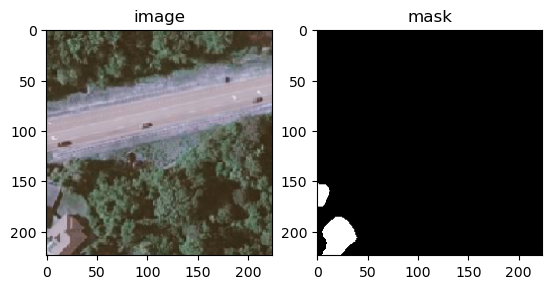

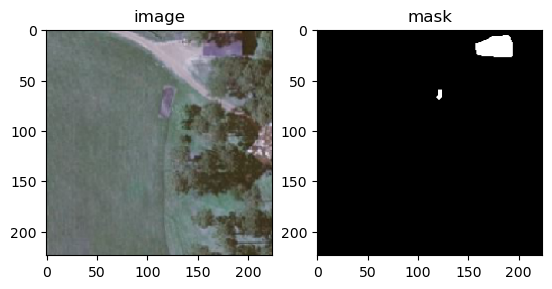

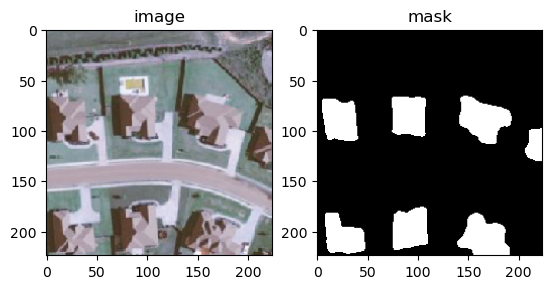

In [27]:
# 로컬 사용시 활성화

last_submit = pd.read_csv(f"{config['base_path']}/0715-00:13:38.csv")
submission_viewer(test_df, last_submit, 10)
submission_viewer(test_df, last_submit, 11)
submission_viewer(test_df, last_submit, 5)